# PLANT TYPE DETECTION

## Import Library

In [1]:
# TensorFlow and Keras - Core libraries for building and training neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Standard Libraries - Built-in libraries for file handling and operations
import os
import zipfile
import pickle
import shutil

# OpenCV - Library for image processing
import cv2

# Data Manipulation and Visualization - Libraries for handling and visualizing data
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Tabulate - Library for creating formatted tables
from tabulate import tabulate

# Ensure matplotlib can be used within the notebook
%matplotlib inline

## Extracting the Dataset

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the zip file in Google Drive
zip_file_path = '/content/drive/My Drive/Colab Notebooks/plant_type_datasets.zip'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/plant_type_datasets')

# Path ke folder dataset
base_dataset_path = '/content/plant_type_datasets/plant_type_datasets'

# List of plant types
plant_types = ['apple', 'bell pepper', 'cabbage', 'carrot', 'cauliflower', 'corn', 'grape', 'peanut', 'peper chili', 'potato', 'shallot', 'soybeans', 'strawberry', 'tomato']

# Initialize a list to hold data
data = []

# Loop through each plant type folder and collect image paths and labels
for plant_type in plant_types:
    plant_folder_path = os.path.join(base_dataset_path, plant_type)
    for img_file in os.listdir(plant_folder_path):
        if img_file.endswith(".jpg"):
            data.append([os.path.join(plant_folder_path, img_file), plant_type])

# Convert the list to a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Use stratified sampling to split the data into training, validation, and testing sets
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=4)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Define the paths for the train, validation, and test directories
base_output_dir = './plants_type_dataset'
train_dir = os.path.join(base_output_dir, 'Train_Set_Folder')
validation_dir = os.path.join(base_output_dir, 'Validation_Set_Folder')
test_dir = os.path.join(base_output_dir, 'Test_Set_Folder')

# Create the output directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to copy files to the respective directories
def copy_files(df, output_dir):
    for _, row in df.iterrows():
        label_dir = os.path.join(output_dir, row['label'])
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(row['filepath'], label_dir)

# Copy the files to the respective directories
copy_files(train_df, train_dir)
copy_files(validation_df, validation_dir)
copy_files(test_df, test_dir)

# Print directories to verify
print(f"Train Directory: {train_dir}")
print(f"Validation Directory: {validation_dir}")
print(f"Test Directory: {test_dir}")

Mounted at /content/drive
Train Directory: ./plants_type_dataset/Train_Set_Folder
Validation Directory: ./plants_type_dataset/Validation_Set_Folder
Test Directory: ./plants_type_dataset/Test_Set_Folder


In [3]:
# Function to count classes and files
def count_classes_and_files(directory):
    """
    Counts the number of classes and jpg files in the given directory.
    """
    class_folders = os.listdir(directory)
    num_classes = len(class_folders)
    file_counts = {}
    total_jpg_count = 0

    for class_folder in class_folders:
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            jpg_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
            file_counts[class_folder] = len(jpg_files)
            total_jpg_count += len(jpg_files)

    return num_classes, file_counts, total_jpg_count

# Count the number of classes and files in each directory
# Count classes and files for train, validation, and test directories
train_num_classes, train_file_counts, train_total_jpg = count_classes_and_files(train_dir)
validation_num_classes, validation_file_counts, validation_total_jpg = count_classes_and_files(validation_dir)
test_num_classes, test_file_counts, test_total_jpg = count_classes_and_files(test_dir)

# Create DataFrames for each dataset
# Create DataFrames to store file counts for train, validation, and test sets
train_df = pd.DataFrame(list(train_file_counts.items()), columns=['Class', 'Number of jpg files'])
validation_df = pd.DataFrame(list(validation_file_counts.items()), columns=['Class', 'Number of jpg files'])
test_df = pd.DataFrame(list(test_file_counts.items()), columns=['Class', 'Number of jpg files'])

# Add total row
# Add a row to each DataFrame that sums up the total number of jpg files
train_total = pd.DataFrame([{'Class': 'Total', 'Number of jpg files': train_total_jpg}])
validation_total = pd.DataFrame([{'Class': 'Total', 'Number of jpg files': validation_total_jpg}])
test_total = pd.DataFrame([{'Class': 'Total', 'Number of jpg files': test_total_jpg}])

train_df = pd.concat([train_df, train_total], ignore_index=True)
validation_df = pd.concat([validation_df, validation_total], ignore_index=True)
test_df = pd.concat([test_df, test_total], ignore_index=True)

# Display the results in table format
# Print the results in a tabular format using the tabulate library
print("Train Set:")
print(tabulate(train_df, headers='keys', tablefmt='pretty', showindex=False))

print("\nValidation Set:")
print(tabulate(validation_df, headers='keys', tablefmt='pretty', showindex=False))

print("\nTest Set:")
print(tabulate(test_df, headers='keys', tablefmt='pretty', showindex=False))

Train Set:
+-------------+---------------------+
|    Class    | Number of jpg files |
+-------------+---------------------+
|   peanut    |         518         |
| peper chili |         600         |
|   tomato    |         600         |
|   potato    |         840         |
|   cabbage   |         840         |
|    corn     |         611         |
|    grape    |         620         |
| cauliflower |         840         |
|   shallot   |         600         |
| strawberry  |         601         |
|    apple    |         722         |
|  soybeans   |         600         |
|   carrot    |         840         |
| bell pepper |         600         |
|    Total    |        9432         |
+-------------+---------------------+

Validation Set:
+-------------+---------------------+
|    Class    | Number of jpg files |
+-------------+---------------------+
|   peanut    |         173         |
| peper chili |         200         |
|   tomato    |         200         |
|   potato    |       

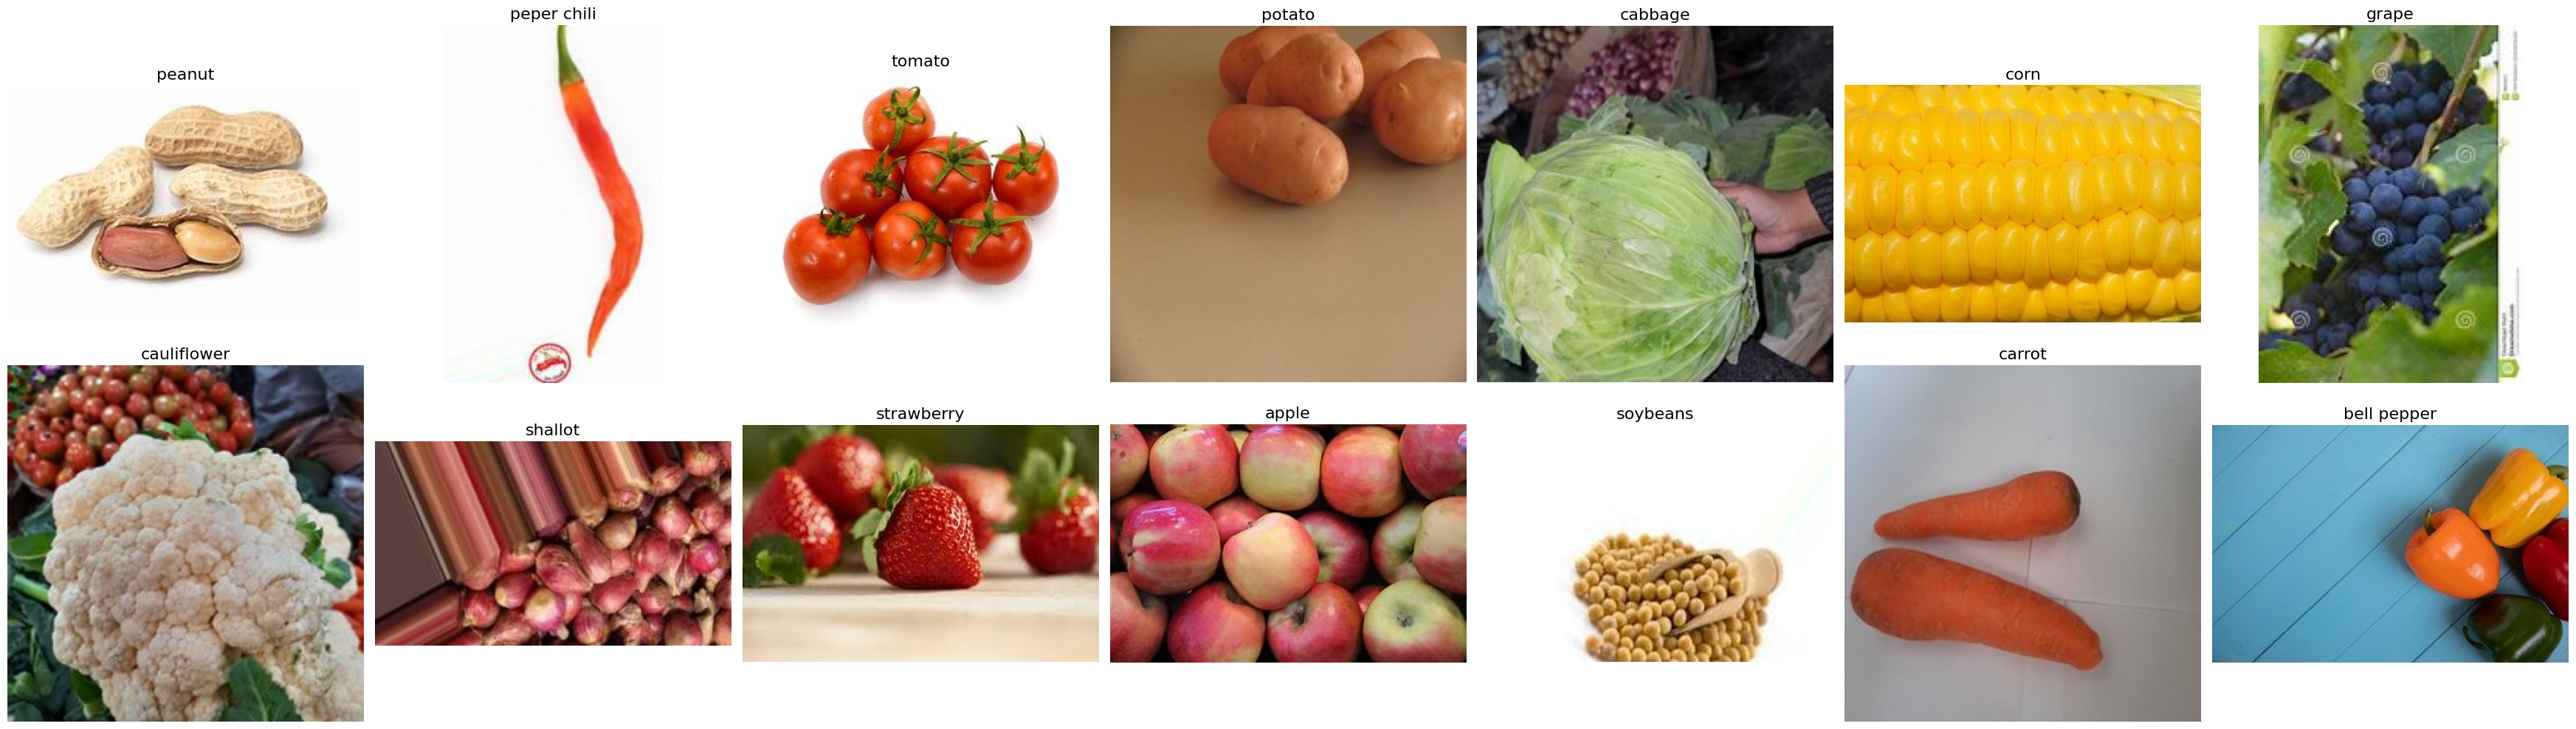

In [5]:
# Set the default plot style for Matplotlib
plt.style.use('default')

# Determine how many classes there are to set up the subplot grid
class_folders = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
num_classes = len(class_folders)
cols = 7  # Number of columns in the subplot grid
rows = (num_classes + cols - 1) // cols  # Calculate required number of rows to accommodate all classes

# Adjust overall size to give each subplot enough space
plt.figure(figsize=(5 * cols, 5 * rows))

# Loop through each class directory to display example images
image_count = 1
for directory in class_folders:
    if directory[0] != '.':  # Skip hidden directories
        files = os.listdir(os.path.join(train_dir, directory))
        if files:
            file = files[0]  # Take the first file for demonstration
            fig = plt.subplot(rows, cols, image_count)
            image_count += 1
            image_path = os.path.join(train_dir, directory, file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB for displaying
            plt.imshow(image)
            plt.title(directory, fontsize=16)
            plt.axis('off')  # Hide axis

# Adjust layout to make the plot more readable
plt.tight_layout()
plt.show()

## Preprocessing the Data Using 'ImageDataGenerator'

In [6]:
# Define image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Image Data Generator
# Define ImageDataGenerator objects for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,          # Rescale pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images within a range of 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally within 20% of the image width
    height_shift_range=0.2,     # Randomly shift images vertically within 20% of the image height
    shear_range=0.2,            # Randomly shear images within a range of 20%
    zoom_range=0.2,             # Randomly zoom images within a range of 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill empty pixels after augmentation using the 'nearest' method
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale pixel values for validation data
test_datagen = ImageDataGenerator(rescale=1./255)   # Only rescale pixel values for test data

# Data Generator for Train, Validation, and Test
# Create data generators for train, validation, and test sets using the defined ImageDataGenerators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),    # Resize images to the specified dimensions
    color_mode='rgb',
    batch_size=batch_size,                  # Set batch size for training
    class_mode='categorical',               # Use categorical class mode for multi-class classification
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Verify some information from the generators
# Print information about the generators to verify the setup
print(f"Train Generator: {len(train_generator)} batches of {train_generator.batch_size} samples each.")
print(f"Validation Generator: {len(validation_generator)} batches of {validation_generator.batch_size} samples each.")
print(f"Test Generator: {len(test_generator)} batches of {test_generator.batch_size} samples each.")

Found 9432 images belonging to 14 classes.
Found 3144 images belonging to 14 classes.
Found 3144 images belonging to 14 classes.
Train Generator: 295 batches of 32 samples each.
Validation Generator: 99 batches of 32 samples each.
Test Generator: 99 batches of 32 samples each.


## Defining and Training CNN Pre-Trained Model

In [8]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the pre-trained layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [9]:
# Define and configure the CNN model architecture with a pre-trained base model
def create_model(input_shape, num_classes):
    # Load the pre-trained base model (example: VGG16)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom classification layers on top of the pre-trained base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Create the model
model = create_model(input_shape=(img_width, img_height, 3), num_classes=len(train_generator.class_indices))

In [10]:
# Print model summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [11]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define the ModelCheckpoint callback
checkpoint_filepath = 'best_model.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model with early stopping
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/30
295/295 [==============================] - ETA: 0s - loss: 1.7766 - accuracy: 0.4366

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


295/295 [==============================] - 123s 352ms/step - loss: 1.7766 - accuracy: 0.4366 - val_loss: 0.5878 - val_accuracy: 0.8216
Epoch 2/30
295/295 [==============================] - 93s 316ms/step - loss: 0.7196 - accuracy: 0.7771 - val_loss: 0.3199 - val_accuracy: 0.9033
Epoch 3/30
295/295 [==============================] - 94s 319ms/step - loss: 0.4562 - accuracy: 0.8607 - val_loss: 0.2702 - val_accuracy: 0.9198
Epoch 4/30
295/295 [==============================] - 95s 322ms/step - loss: 0.3387 - accuracy: 0.8942 - val_loss: 0.2441 - val_accuracy: 0.9278
Epoch 5/30
295/295 [==============================] - 94s 319ms/step - loss: 0.2821 - accuracy: 0.9156 - val_loss: 0.1751 - val_accuracy: 0.9472
Epoch 6/30
295/295 [==============================] - 94s 319ms/step - loss: 0.2212 - accuracy: 0.9359 - val_loss: 0.1906 - val_accuracy: 0.9431
Epoch 7/30
295/295 [==============================] - 95s 321ms/step - loss: 0.1977 - accuracy: 0.9414 - val_loss: 0.1452 - val_accuracy: 0.

## Evaluating the Model Using the Test Set

In [12]:
# Evaluasi model menggunakan test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

99/99 [==============================] - 7s 69ms/step - loss: 0.1567 - accuracy: 0.9539
Test Loss: 0.1566723734140396
Test Accuracy: 0.9538804292678833


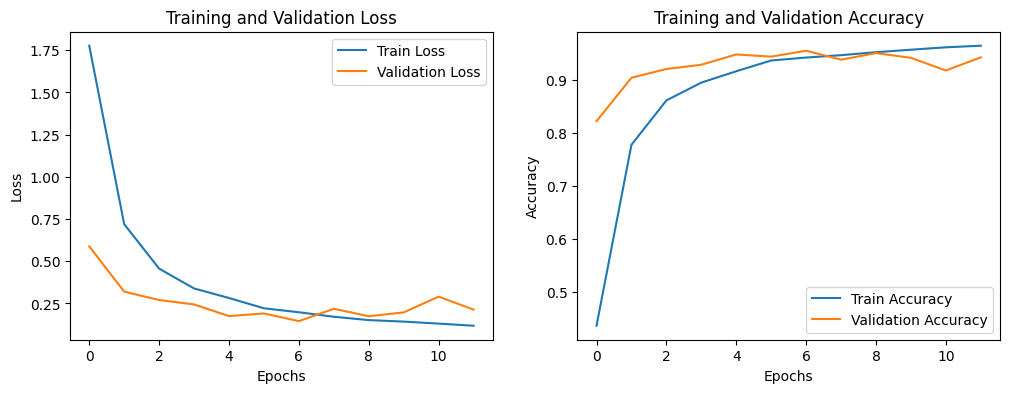

In [13]:
# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

## CNN Model Prediction and Confusion Matrix

99/99 [==============================] - 7s 71ms/step


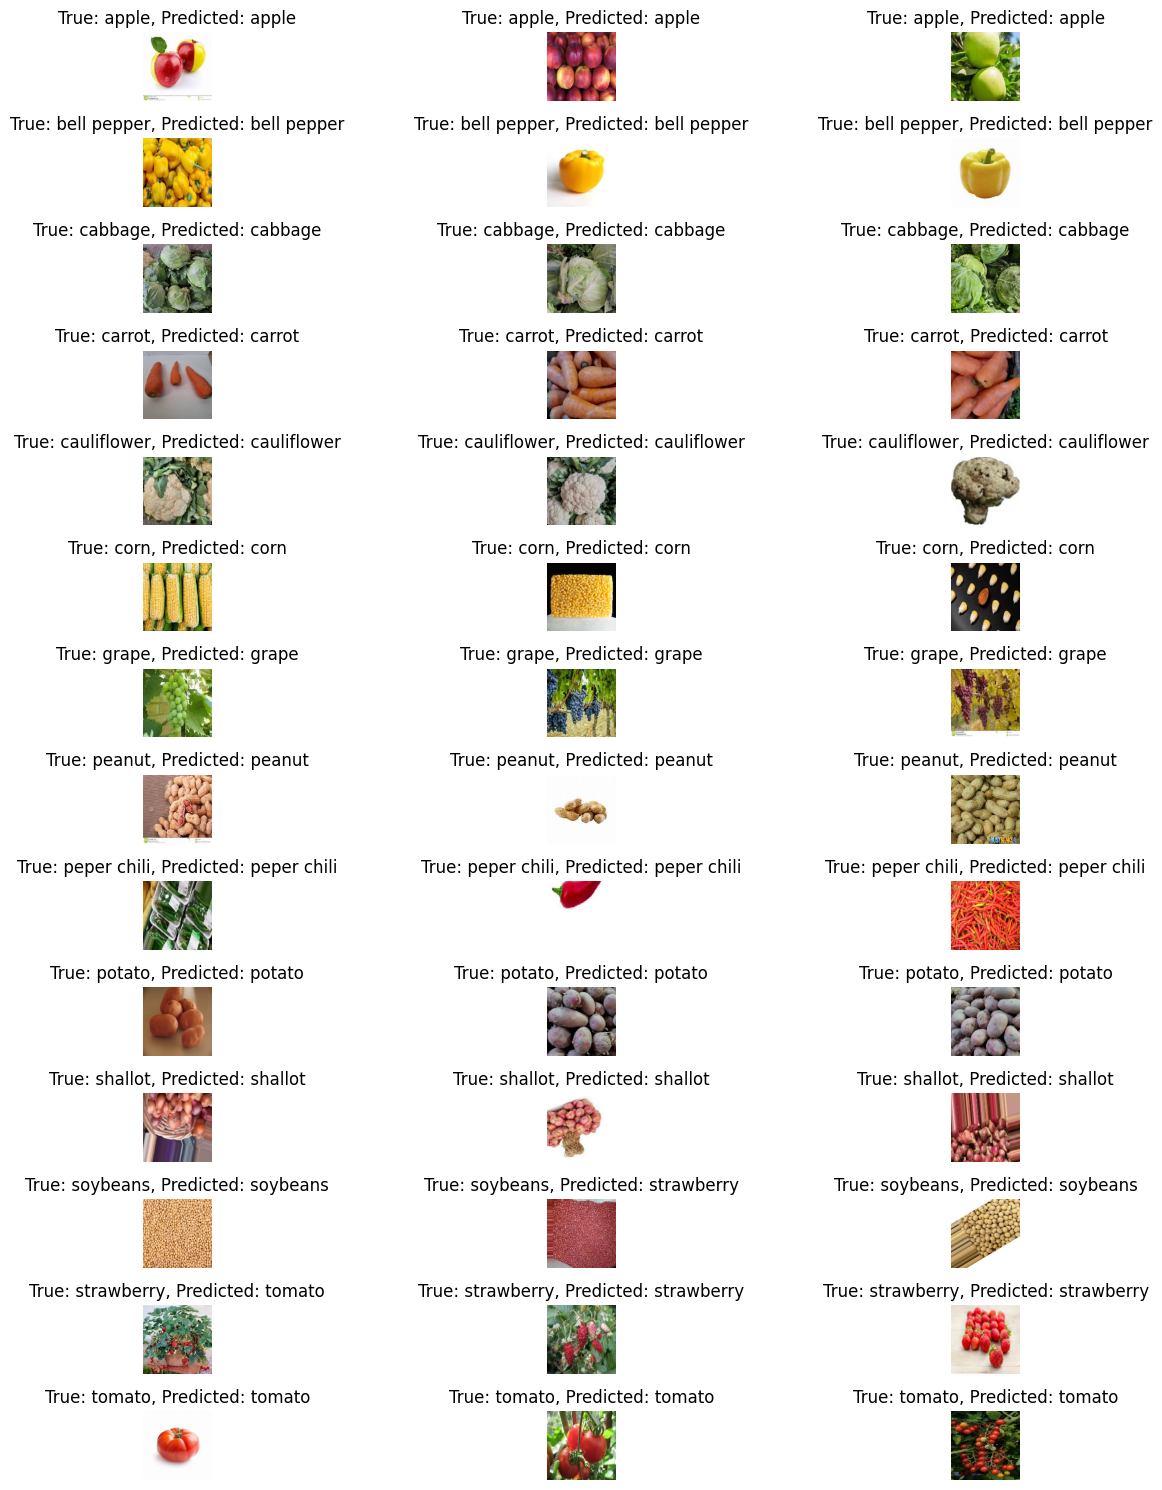

In [15]:
# Load the best model for predictions
best_model = load_model(checkpoint_filepath)

# Prediksi menggunakan test set
test_generator.reset()  # Reset generator for making predictions
predictions = best_model.predict(test_generator, steps=len(test_generator), verbose=1)

# Mendapatkan label sebenarnya
true_labels = test_generator.classes

# Mendapatkan label yang diprediksi
predicted_labels = np.argmax(predictions, axis=1)

# Mengelompokkan gambar berdasarkan kelas sebenarnya
class_images = {}
for i in range(len(true_labels)):
    true_label = true_labels[i]
    if true_label not in class_images:
        class_images[true_label] = []
    class_images[true_label].append(i)

# Display some images with their predicted and true labels
plt.figure(figsize=(15, 15))

plot_count = 1
for class_idx, indices in class_images.items():
    # Pilih 2 contoh acak dari setiap kelas
    selected_indices = random.sample(indices, min(3, len(indices)))
    for i in selected_indices:
        plt.subplot(len(class_images), 3, plot_count)
        plot_count += 1

        image_path = test_generator.filepaths[i]
        img = load_img(image_path, target_size=(img_width, img_height))
        img_array = img_to_array(img) / 255.0  # Normalize the image array

        plt.imshow(img_array)
        true_label = list(test_generator.class_indices.keys())[true_labels[i]]
        predicted_label = list(test_generator.class_indices.keys())[predicted_labels[i]]
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')

plt.tight_layout()
plt.show()

99/99 [==============================] - 10s 97ms/step


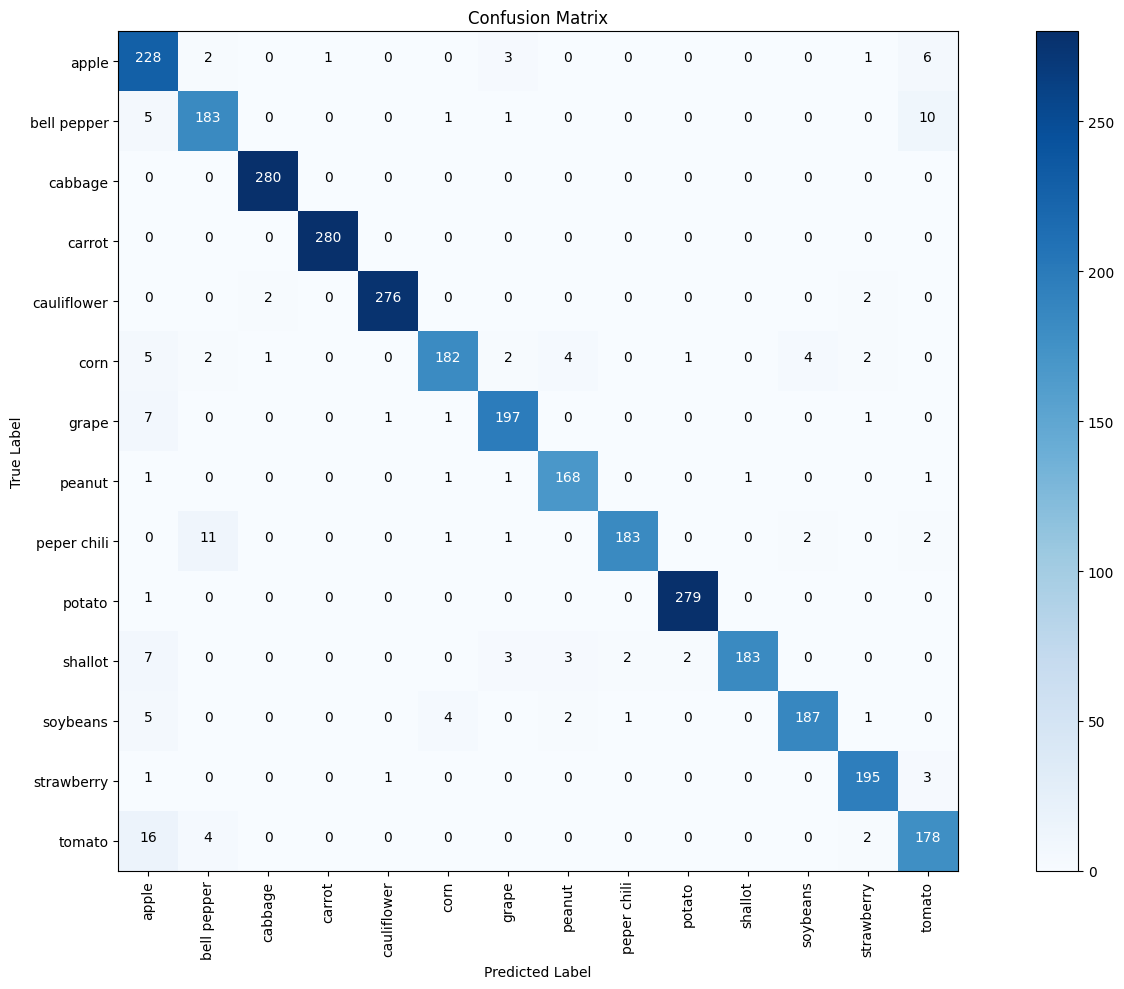

Classification Report:
----------------------
               precision    recall  f1-score   support

       apple     0.8261    0.9461    0.8820       241
 bell pepper     0.9059    0.9150    0.9104       200
     cabbage     0.9894    1.0000    0.9947       280
      carrot     0.9964    1.0000    0.9982       280
 cauliflower     0.9928    0.9857    0.9892       280
        corn     0.9579    0.8966    0.9262       203
       grape     0.9471    0.9517    0.9494       207
      peanut     0.9492    0.9711    0.9600       173
 peper chili     0.9839    0.9150    0.9482       200
      potato     0.9894    0.9964    0.9929       280
     shallot     0.9946    0.9150    0.9531       200
    soybeans     0.9689    0.9350    0.9517       200
  strawberry     0.9559    0.9750    0.9653       200
      tomato     0.8900    0.8900    0.8900       200

    accuracy                         0.9539      3144
   macro avg     0.9534    0.9495    0.9508      3144
weighted avg     0.9557    0.9539

In [16]:
# Predict classes for the test set
test_predictions = model.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)

# Get true classes for the test set
true_classes = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Create a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
plt.figure(figsize=(16, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the numerical values in the cells
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
clr = classification_report(true_classes, predicted_classes, target_names=class_names, digits=4)
print("Classification Report:\n----------------------\n", clr)

## Saving the Model in Different Formats:
- Pickle

In [17]:
import pickle

# Save the model using Pickle
with open('plants_type_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Load the model using Pickle
with open('plants_type_model.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

- H5

In [18]:
# Save the model using H5 format
model.save('plants_type_model.h5')

# Load the model using H5 format
from tensorflow.keras.models import load_model
loaded_model_h5 = load_model('plants_type_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


- TensorFlow SavedModel

In [19]:
# Save the model using TensorFlow SavedModel format
model.save('saved_model/plants_type_model')

# Load the model using TensorFlow SavedModel format
loaded_model_saved = tf.keras.models.load_model('saved_model/plants_type_model')

- TensorFlow Lite

In [20]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('plants_type_model.tflite', 'wb') as file:
    file.write(tflite_model)

# Load the TensorFlow Lite model (for inference, not training)
interpreter = tf.lite.Interpreter(model_path='plants_type_model.tflite')
interpreter.allocate_tensors()

# Getting input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()